In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import curve_fit

#Use better looking plot settings
plt.rc('font',family='serif')

RootOrange = '#FF5715'
Orange120 = '#EE4300'

In [2]:
## Code here or write here
## Read in the advertising data
RootData = pd.read_csv("Root_Insurance_data.csv")

## Make a train test split, setting aside 25% of the data as a test for later
#RootData_train = RootData.copy().sample(frac=.75,random_state = 23)
#RootData_test = RootData.copy().drop(RootData.index)

#Actually don't think we need these yet

In [3]:
RootData

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0
...,...,...,...,...,...,...,...,...
9995,N,1,2,S,10.0,3,True,0
9996,unknown,3,2,M,10.0,3,False,0
9997,Y,3,1,S,10.0,5,False,0
9998,unknown,3,1,M,10.0,3,False,0


In [4]:
def basic_info(Category=None, Value=None, RankNum=0, printout=True):
    # Find the clicks per ad, policies sold per ad, and policies sold per click for a subset of the data
    # Return these values, along with their associated uncertainties
    
    if Category==None: #get all the data without cutting on a condition
        ad_clicks = len( RootData.loc[RootData["click"]==True] )
        policies_sold = len( RootData.loc[RootData["policies_sold"]==1] )
        total_ads = len(RootData)
        print(total_ads,'total ads')
        print(ad_clicks,'ad clicks')
        print(policies_sold,'policies sold')
    elif RankNum == 0: #look at only the data specified by the Category and its Value
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[RootData[Category]==Value])
    else: #look at only the data specified by the Category and its Value for rank=RankNum
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[(RootData["rank"]==RankNum) & (RootData[Category]==Value)])
    
    #print(ad_clicks,'ad clicks')
    #print(policies_sold,'policies sold')
    #print(total_ads,'total ads')
    
    if total_ads > 0:
        clicks_per_ad = ad_clicks/total_ads
        policies_per_ad = policies_sold/total_ads
        policies_per_click = policies_per_ad/clicks_per_ad
        err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
    else:
        return ['---', '---', '---', '---', '---', '---']
    
    if printout == True:
        #print(ad_clicks,'ad clicks')
        #print(policies_sold,'policies sold')
        #print(total_ads,'total ads')
        print(round(clicks_per_ad,3),'+/-',round(err_clicks_per_ad,4),'clicks per ad')
        print(round(policies_per_ad,3),'+/-',round(err_policies_per_ad,4),'policies sold per ad')
        print(round(policies_per_click,3),'+/-',round(err_policies_per_click,4),'policies sold per click')
    
    return [clicks_per_ad, err_clicks_per_ad, policies_per_ad, err_policies_per_ad, policies_per_click, err_policies_per_click]

In [5]:
insured_vals = list( set(RootData["Currently Insured"]) )
vehicles_vals = list( set(RootData["Number of Vehicles"]) )
drivers_vals = list( set(RootData["Number of Drivers"]) )
marital_vals = list( set(RootData["Marital Status"]) )

categories_df = pd.DataFrame({
                        'Insured':[],
                        'Vehicles':[],
                        'Drivers':[],
                        'Marital Status':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                        'Total Clicks':[],
                        'Total Click Uncertainty':[],
                        'Total Policies Sold':[],
                        'Total Policies Sold Uncertainty':[],
                        'Expected Clicks at Rank 5':[],
                        'Uncertainty in Rank 5 Clicks Estimate':[],
                        'Expected Policies Sold at Rank 5':[],
                        'Uncertainty in Rank 5 Sales Estimate':[],
                        'Expected Clicks per Ad':[],
                        'AvgRank':[],
                        'Rank1':[],
                        'Rank2':[],
                        'Rank3':[],
                        'Rank4':[],
                        'Rank5':[]
                        })

#Will need the expected clicks per ad for an ad displayed in ranks 1-5
R1ExpClickPA = basic_info("rank",1,printout=False)[0]
R1ErrClickPa = basic_info("rank",1,printout=False)[1]
R2ExpClickPA = basic_info("rank",2,printout=False)[0]
R2ErrClickPa = basic_info("rank",2,printout=False)[1]
R3ExpClickPA = basic_info("rank",3,printout=False)[0]
R3ErrClickPa = basic_info("rank",3,printout=False)[1]
R4ExpClickPA = basic_info("rank",4,printout=False)[0]
R4ErrClickPa = basic_info("rank",4,printout=False)[1]
R5ExpClickPA = basic_info("rank",5,printout=False)[0]
R5ErrClickPa = basic_info("rank",5,printout=False)[1]

for insured_val in insured_vals:
    for vehicles_val in vehicles_vals:
        for drivers_val in drivers_vals:
            for marital_val in marital_vals:
                Ranks = [ len(RootData.loc[(RootData["rank"]==i+1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)]) for i in range(5) ]
                ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                total_ads = len(RootData.loc[(RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                if (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4]) > 0:
                    #probably best to just leave out the empty unknown/3/2/S bin that has no ads
                    #which is what this if statement does
                    
                    clicks_per_ad = ad_clicks/total_ads
                    policies_per_ad = policies_sold/total_ads
                    policies_per_click = policies_per_ad/clicks_per_ad
                    
                    err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
                    
                    ExpClickTot = R1ExpClickPA*Ranks[0] + R2ExpClickPA*Ranks[1] + R3ExpClickPA*Ranks[2] + R4ExpClickPA*Ranks[3] + R5ExpClickPA*Ranks[4]
                    AvgRank = ( 1*Ranks[0]+2*Ranks[1]+3*Ranks[2]+4*Ranks[3]+5*Ranks[4] ) / (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ExpClickperAd = ExpClickTot/sum(Ranks)
                    
                    #Number of expected clicks if we were to place all ads for customers of these traits in rank 5
                    ExpClickR5 = R5ExpClickPA*(Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ErrClickR5 = ExpClickR5*np.sqrt(R5ErrClickPa**2)
                    ExpPoliciesR5 = policies_per_click*ExpClickR5
                    ErrPoliciesR5 = ExpPoliciesR5 * np.sqrt( (err_policies_per_click/policies_per_click)**2 + (ErrClickR5/ExpClickR5)**2 )
                    
                    #print(insured_val, vehicles_val, drivers_val, marital_val, AvgRank_Val, policies_per_click)
                    new_row = {'Insured':insured_val, 'Vehicles':vehicles_val, 'Drivers':drivers_val,
                               'Marital Status':marital_val, 'Policies Sold per Click':policies_per_click,
                               'Policies Sold per Click Uncertainty':err_policies_per_click,
                               'Total Clicks':ad_clicks, 'Total Click Uncertainty':np.sqrt(ad_clicks),
                               'Total Policies Sold':policies_sold, 'Total Policies Sold Uncertainty':np.sqrt(policies_sold),
                               'Expected Clicks at Rank 5':ExpClickR5, 'Uncertainty in Rank 5 Clicks Estimate':ErrClickR5,
                               'Expected Policies Sold at Rank 5':ExpPoliciesR5,'Uncertainty in Rank 5 Sales Estimate':ErrPoliciesR5,
                               'Expected Clicks per Ad':ExpClickperAd, 'AvgRank':AvgRank,
                               'Rank1':Ranks[0],'Rank2':Ranks[1], 'Rank3':Ranks[2],'Rank4':Ranks[3], 'Rank5':Ranks[4]
                               }
                    categories_df = categories_df.append(new_row, ignore_index=True)

categories_df = categories_df.sort_values(by=['Policies Sold per Click'], ascending=False).reset_index(drop=True)
categories_df


,Insured,Vehicles,Drivers,Marital Status,Policies Sold per Click,Policies Sold per Click Uncertainty,Total Clicks,Total Click Uncertainty,Total Policies Sold,Total Policies Sold Uncertainty,...,Uncertainty in Rank 5 Clicks Estimate,Expected Policies Sold at Rank 5,Uncertainty in Rank 5 Sales Estimate,Expected Clicks per Ad,AvgRank,Rank1,Rank2,Rank3,Rank4,Rank5
0,N,3.0,1.0,M,0.600000,0.258296,15.0,3.872983,9.0,3.000000,...,0.017502,3.400698,1.464017,0.063673,4.305660,0.0,0.0,51.0,82.0,132.0
1,N,1.0,1.0,S,0.581395,0.154520,43.0,6.557439,25.0,5.000000,...,0.017898,3.369860,0.895682,0.135176,3.435424,0.0,59.0,84.0,79.0,49.0
2,N,1.0,1.0,M,0.560000,0.192444,25.0,5.000000,14.0,3.741657,...,0.019813,3.593191,1.234849,0.123254,3.573333,0.0,53.0,87.0,95.0,65.0
3,unknown,1.0,1.0,S,0.543307,0.093331,127.0,11.269428,69.0,8.306624,...,0.018493,3.253677,0.559019,0.392509,1.621429,148.0,90.0,42.0,0.0,0.0
4,unknown,1.0,2.0,M,0.542857,0.099907,105.0,10.246951,57.0,7.549834,...,0.019417,3.413531,0.628312,0.386952,1.659864,155.0,84.0,55.0,0.0,0.0
5,unknown,1.0,1.0,M,0.526786,0.095231,112.0,10.583005,59.0,7.681146,...,0.019417,3.312473,0.598907,0.380966,1.690476,150.0,85.0,59.0,0.0,0.0
6,N,3.0,2.0,M,0.523810,0.199229,21.0,4.582576,11.0,3.316625,...,0.021531,3.652262,1.389169,0.067401,4.245399,0.0,0.0,71.0,104.0,151.0
7,unknown,2.0,1.0,M,0.488095,0.102101,84.0,9.165151,41.0,6.403124,...,0.017700,2.797759,0.585309,0.365601,1.761194,122.0,88.0,58.0,0.0,0.0
8,Y,1.0,1.0,S,0.487179,0.104526,78.0,8.831761,38.0,6.164414,...,0.019153,3.021746,0.648391,0.246573,2.548276,60.0,74.0,93.0,63.0,0.0
9,N,2.0,2.0,S,0.468750,0.151346,32.0,5.656854,15.0,3.872983,...,0.020870,3.168103,1.022936,0.117588,3.632911,0.0,48.0,94.0,100.0,74.0


In [6]:
#This is the amount (in dollars) that we are assuming will increase a bid's rank placement by 1 spot
RankValue = 2.50

# We'll again assume that the lowest possible bid one can make is $0.01,
# since I doubt the search host would let you bid $0.00
MinBidVal = 0.01

PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])


In [7]:
def UpdatedBidInfo(cat_ind, NewBid, printout=True):
    #Figure out how ad clicks and subsequent policy sales change when the $10 bid is changed to NewBid
    #This assumes that increasing a bid by RankValue will shift the ad up one rank
    
    i = cat_ind #the index of the entry in categories_df
    
    if NewBid == 10.00+4.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank1s +=categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank5"]
        Rank2s = 0
        Rank3s = 0
        Rank4s = 0
        Rank5s = 0
    elif (NewBid < 10.00+4.0*RankValue) and (NewBid > 10.00+3.0*RankValue):
        frac = (NewBid - (10.00+3.0*RankValue)) / RankValue
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank1s +=categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank5"]*frac
        Rank2s = categories_df.iloc[i]["Rank5"]*(1.0-frac)
        Rank3s = 0
        Rank4s = 0
        Rank5s = 0
    elif NewBid == 10.00+3.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank1s +=categories_df.iloc[i]["Rank4"]
        Rank2s = categories_df.iloc[i]["Rank5"]
        Rank3s = 0
        Rank4s = 0
        Rank5s = 0
    elif (NewBid < 10.00+3.0*RankValue) and (NewBid > 10.00+2.0*RankValue):
        frac = (NewBid - (10.00+2.0*RankValue)) / RankValue
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank1s +=categories_df.iloc[i]["Rank4"]*frac
        Rank2s = categories_df.iloc[i]["Rank5"]*frac+categories_df.iloc[i]["Rank4"]*(1.0-frac)
        Rank3s = categories_df.iloc[i]["Rank5"]*(1.0-frac)
        Rank4s = 0
        Rank5s = 0
    elif NewBid == 10.00+2.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank2s = categories_df.iloc[i]["Rank4"]
        Rank3s = categories_df.iloc[i]["Rank5"]
        Rank4s = 0
        Rank5s = 0
    elif (NewBid < 10.00+2.0*RankValue) and (NewBid > 10.00+1.0*RankValue):
        frac = (NewBid - (10.00+1.0*RankValue)) / RankValue
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]*frac
        Rank2s = categories_df.iloc[i]["Rank4"]*frac+categories_df.iloc[i]["Rank3"]*(1.0-frac)
        Rank3s = categories_df.iloc[i]["Rank5"]*frac+categories_df.iloc[i]["Rank4"]*(1.0-frac)
        Rank4s = categories_df.iloc[i]["Rank5"]*(1.0-frac)
        Rank5s = 0
    elif NewBid == 10.00+1.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]
        Rank2s = categories_df.iloc[i]["Rank3"]
        Rank3s = categories_df.iloc[i]["Rank4"]
        Rank4s = categories_df.iloc[i]["Rank5"]
        Rank5s = 0
    elif (NewBid < 10.00+1.0*RankValue) and (NewBid > 10.00):
        frac = (NewBid - 10.00) / RankValue
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]*frac
        Rank2s = categories_df.iloc[i]["Rank3"]*frac+categories_df.iloc[i]["Rank2"]*(1.0-frac)
        Rank3s = categories_df.iloc[i]["Rank4"]*frac+categories_df.iloc[i]["Rank3"]*(1.0-frac)
        Rank4s = categories_df.iloc[i]["Rank5"]*frac+categories_df.iloc[i]["Rank4"]*(1.0-frac)
        Rank5s = categories_df.iloc[i]["Rank5"]*(1.0-frac)
    elif NewBid == 10.00:
        Rank1s = categories_df.iloc[i]["Rank1"]
        Rank2s = categories_df.iloc[i]["Rank2"]
        Rank3s = categories_df.iloc[i]["Rank3"]
        Rank4s = categories_df.iloc[i]["Rank4"]
        Rank5s = categories_df.iloc[i]["Rank5"]
    elif (NewBid < 10.00) and (NewBid > 10.00-1.0*RankValue):
        frac = (NewBid - (10.00-1.0*RankValue)) / RankValue
        Rank1s = categories_df.iloc[i]["Rank1"]*frac
        Rank2s = categories_df.iloc[i]["Rank2"]*frac+categories_df.iloc[i]["Rank1"]*(1.0-frac)
        Rank3s = categories_df.iloc[i]["Rank3"]*frac+categories_df.iloc[i]["Rank2"]*(1.0-frac)
        Rank4s = categories_df.iloc[i]["Rank4"]*frac+categories_df.iloc[i]["Rank3"]*(1.0-frac)
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]*(1.0-frac)
    elif NewBid == 10.00-1.0*RankValue:
        Rank1s = 0
        Rank2s = categories_df.iloc[i]["Rank1"]
        Rank3s = categories_df.iloc[i]["Rank2"]
        Rank4s = categories_df.iloc[i]["Rank3"]
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]
    elif (NewBid < 10.00-1.0*RankValue) and (NewBid > 10.00-2.0*RankValue):
        frac = (NewBid - (10.00-2.0*RankValue)) / RankValue
        Rank1s = 0
        Rank2s = categories_df.iloc[i]["Rank1"]*frac
        Rank3s = categories_df.iloc[i]["Rank2"]*frac+categories_df.iloc[i]["Rank1"]*(1.0-frac)
        Rank4s = categories_df.iloc[i]["Rank3"]*frac+categories_df.iloc[i]["Rank2"]*(1.0-frac)
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]*(1.0-frac)
    elif NewBid == 10.00-2.0*RankValue:
        Rank1s = 0
        Rank2s = 0
        Rank3s = categories_df.iloc[i]["Rank1"]
        Rank4s = categories_df.iloc[i]["Rank2"]
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
    elif (NewBid < 10.00-2.0*RankValue) and (NewBid > 10.00-3.0*RankValue):
        frac = (NewBid - (10.00-3.0*RankValue)) / RankValue
        Rank1s = 0
        Rank2s = 0
        Rank3s = categories_df.iloc[i]["Rank1"]*frac
        Rank4s = categories_df.iloc[i]["Rank2"]*frac+categories_df.iloc[i]["Rank1"]*(1.0-frac)
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
        Rank5s +=categories_df.iloc[i]["Rank2"]*(1.0-frac)
    elif NewBid == 10.00-3.0*RankValue:
        Rank1s = 0
        Rank2s = 0
        Rank3s = 0
        Rank4s = categories_df.iloc[i]["Rank1"]
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
        Rank5s +=categories_df.iloc[i]["Rank2"]
    elif (NewBid < 10.00-3.0*RankValue) and (NewBid > 10.00-4.0*RankValue):
        frac = (NewBid - (10.00-4.0*RankValue)) / RankValue
        Rank1s = 0
        Rank2s = 0
        Rank3s = 0
        Rank4s = categories_df.iloc[i]["Rank1"]*frac
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
        Rank5s +=categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank1"]*(1.0-frac)
    elif NewBid <= 10.00-4.0*RankValue:
        #These will include MinBidVal bids
        Rank1s = 0
        Rank2s = 0
        Rank3s = 0
        Rank4s = 0
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
        Rank5s +=categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank1"]

    ExpClickTot = R1ExpClickPA*Rank1s+R2ExpClickPA*Rank2s+R3ExpClickPA*Rank3s+R4ExpClickPA*Rank4s+R5ExpClickPA*Rank5s
    if Rank1s > 0:
        R1ClickTotErr = R1ExpClickPA*Rank1s * np.sqrt( (R1ErrClickPa/R1ExpClickPA)**2.0 + (np.sqrt(Rank1s)/Rank1s)**2.0 )
    else:
        R1ClickTotErr = 0
    if Rank2s > 0:
        R2ClickTotErr = R2ExpClickPA*Rank2s * np.sqrt( (R2ErrClickPa/R2ExpClickPA)**2.0 + (np.sqrt(Rank2s)/Rank2s)**2.0 )
    else:
        R2ClickTotErr = 0
    if Rank3s > 0:
        R3ClickTotErr = R3ExpClickPA*Rank3s * np.sqrt( (R3ErrClickPa/R3ExpClickPA)**2.0 + (np.sqrt(Rank3s)/Rank3s)**2.0 )
    else:
        R3ClickTotErr = 0
    if Rank4s > 0:
        R4ClickTotErr = R4ExpClickPA*Rank4s * np.sqrt( (R4ErrClickPa/R4ExpClickPA)**2.0 + (np.sqrt(Rank4s)/Rank4s)**2.0 )
    else:
        R4ClickTotErr = 0
    if Rank5s > 0:
        R5ClickTotErr = R5ExpClickPA*Rank5s * np.sqrt( (R5ErrClickPa/R5ExpClickPA)**2.0 + (np.sqrt(Rank5s)/Rank5s)**2.0 )
    else:
        R5ClickTotErr = 0
    ExpClickTotErr = np.sqrt( R1ClickTotErr**2.0+R2ClickTotErr**2.0+R3ClickTotErr**2.0+R4ClickTotErr**2.0+R5ClickTotErr**2.0 )
    
    PSpC = categories_df.iloc[i]["Policies Sold per Click"]
    PspC_Err = categories_df.iloc[i]["Policies Sold per Click Uncertainty"]
    PoliciesSold = ExpClickTot*PSpC
    PoliciesSoldErr = PoliciesSold * np.sqrt( (ExpClickTotErr/ExpClickTot)**2 + (PspC_Err/PSpC)**2  )
    
    #Directly take the Total Policies Sold and associated uncertainty from known $10 bid data
    if NewBid == 10.00:
        ExpClickTot = categories_df.iloc[i]["Total Clicks"]
        ExpClickTotErr = categories_df.iloc[i]["Total Click Uncertainty"]
        PoliciesSold = categories_df.iloc[i]["Total Policies Sold"]
        PoliciesSoldErr = categories_df.iloc[i]["Total Policies Sold Uncertainty"]
    
    #Deal with cases where increasing/decreasing the bid has no impact
    #I.e., no need to pay a maximum bid if the $10 bid never resulted in a placement lower than Rank 3
    #In this case we would have already placed all ads in this customer combo into Rank 1 by bidding $10+2*RankVal
    TrueBid = NewBid
    if (categories_df.iloc[i]["Rank1"]==0) and (categories_df.iloc[i]["Rank2"]==0):
        #if (NewBid == 10.00-3.0*RankValue) or (NewBid == 10.00-2.0*RankValue):
        if (NewBid <= 10.00-2.0*RankValue):
            TrueBid = MinBidVal
    elif (categories_df.iloc[i]["Rank1"]==0):
        #if (NewBid == 10.00-3.0*RankValue):
        if (NewBid <= 10.00-3.0*RankValue):
            TrueBid = MinBidVal
    elif (categories_df.iloc[i]["Rank5"]==0) and (categories_df.iloc[i]["Rank4"]==0):
        #if (NewBid == 10.00+4.0*RankValue) or (NewBid == 10.00+3.0*RankValue):
        if (NewBid >= 10.00+2.0*RankValue):
            TrueBid = 10.00+2.0*RankValue
    elif (categories_df.iloc[i]["Rank5"]==0):
        #if (NewBid == 10.00+4.0*RankValue):
        if (NewBid >= 10.00+3.0*RankValue):
            TrueBid = 10.00+3.0*RankValue
        
    if printout==True:
        print(categories_df.iloc[i]["Insured"],'\t',
              categories_df.iloc[i]["Vehicles"],'\t',
              categories_df.iloc[i]["Drivers"],'\t',
              categories_df.iloc[i]["Marital Status"],'\t',
              Rank1s+Rank2s+Rank3s+Rank4s+Rank5s,'\t',
              round(PSpC,3),'\t',
              NewBid,'\t',
              TrueBid,'\t',
              round(PoliciesSold,2),'\t',
              round(ExpClickTot,1))

    return PoliciesSold, ExpClickTot, TrueBid


In [8]:
print("Insured, Vehicles, Drivers, Marital Status, Total Ads, Policies Sold per Click, Nom. Bid, True Bid, Policies Sold, Ad Clicks")
print()

MorePossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.5*RankValue, 10.00+3.0*RankValue, 10.00+2.5*RankValue,
                             10.00+2.0*RankValue, 10.00+1.5*RankValue, 10.00+1.0*RankValue, 10.00+0.5*RankValue,
                             10.00+0.0*RankValue, 10.00-0.5*RankValue, 10.00-1.0*RankValue, 10.00-1.5*RankValue,
                             10.00-2.0*RankValue, 10.00-2.5*RankValue, 10.00-3.0*RankValue, 10.00-3.5*RankValue,
                             MinBidVal])

#for i in range(len(categories_df)):
for i in [0,7]:
    for Bid in MorePossibleBids:
        UpdatedBidInfo(i, Bid)
    print()

Insured, Vehicles, Drivers, Marital Status, Total Ads, Policies Sold per Click, Nom. Bid, True Bid, Policies Sold, Ad Clicks

N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 20.0 	 20.0 	 83.69 	 139.5
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 18.75 	 18.75 	 74.23 	 123.7
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 17.5 	 17.5 	 64.76 	 107.9
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 16.25 	 16.25 	 53.29 	 88.8
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 15.0 	 15.0 	 41.82 	 69.7
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 13.75 	 13.75 	 32.09 	 53.5
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 12.5 	 12.5 	 22.35 	 37.3
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 11.25 	 11.25 	 16.24 	 27.1
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 10.0 	 10.0 	 9.0 	 15.0
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 8.75 	 8.75 	 7.67 	 12.8
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 7.5 	 7.5 	 5.21 	 8.7
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 6.25 	 6.25 	 4.3 	 7.2
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 5.0 	 0.01 	 3.4 	 5.7
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 3.75 	 0.01 	 3.4 	 5.7
N 	 3.0 	 1.0 	 M 	 265.0 

In [9]:
def BidStrategyStats(BidValues, printout=True):
    #Given a set of bids, predict how many sales will be made and how much each will cost
    
    if not len(BidValues)==len(categories_df):
        print("Error. BidValues must contain a bid prescription for each customer combination.")
        return
    
    TotalAdCost = 0.0
    PolicySales = []
    AdClicks = []
    TrueBids = []
    for i in range(len(categories_df)):
        Bid = BidValues[i]
        SalesNum, AdClick, TrueBid = UpdatedBidInfo(i, Bid, printout=False)
        TotalAdCost += TrueBid*AdClick
        PolicySales.append(SalesNum)
        AdClicks.append(AdClick)
        TrueBids.append(TrueBid)
    
    PolicySales = sum(PolicySales)
    CostPerAd = TotalAdCost/PolicySales
    
    if printout == True:
        print(round(CostPerAd,2),'\t',
              round(PolicySales,1),'\t',
              TrueBids)
    
    return(CostPerAd,PolicySales,TrueBids)

In [10]:
PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])

RandomSampleN = 5

AdCosts = []
TotSales = []
SetBids = []

def FillTestBids(N, int_low, int_high):
    for i in range(N):
        TestBids = []
        for j in range(35):
            TestBids.append( PossibleBids[np.random.randint(int_low, int_high)] )
        AdCost, TotSale, TrueBids = BidStrategyStats(TestBids, printout=False)
        AdCosts.append(AdCost)
        TotSales.append(TotSale)
        SetBids.append(TrueBids)


#Selective sampling trying to fill out the near-limit space in the plot below
FillTestBids(RandomSampleN, 0, 2)
FillTestBids(RandomSampleN, 1, 3)
FillTestBids(RandomSampleN, 2, 4)
FillTestBids(RandomSampleN, 3, 5)
FillTestBids(RandomSampleN, 4, 6)
FillTestBids(RandomSampleN, 5, 7)
FillTestBids(RandomSampleN, 6, 8)
FillTestBids(RandomSampleN, 7, 9)

FillTestBids(RandomSampleN, 0, 3)
FillTestBids(RandomSampleN, 1, 4)
FillTestBids(RandomSampleN, 2, 5)
FillTestBids(RandomSampleN, 3, 6)
FillTestBids(RandomSampleN, 4, 7)
FillTestBids(RandomSampleN, 5, 8)
FillTestBids(RandomSampleN, 6, 9)

NearLim_AdCosts = AdCosts.copy()
NearLim_TotSales = TotSales.copy()


#Now get a random sample of the whole set of bid options
AdCosts = []
TotSales = []

FillTestBids(500*RandomSampleN, 0, 9)

18.001444845368635 410.2608356981722


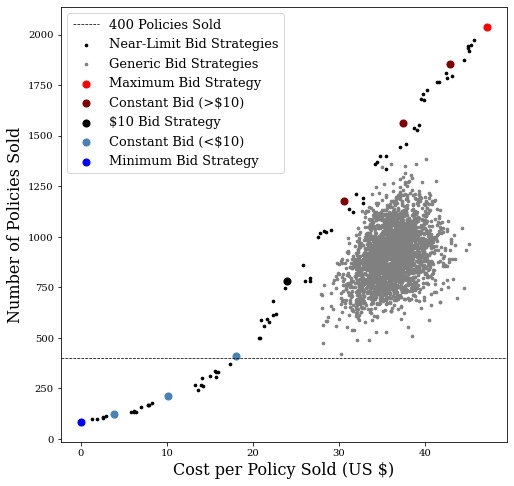

In [11]:
plt.figure(figsize=(8,8))

plt.scatter(NearLim_AdCosts, NearLim_TotSales, color='k', label='Near-Limit Bid Strategies', s=7)
plt.scatter(AdCosts, TotSales, color='0.5', label='Generic Bid Strategies', s=7)

plt.axhline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

#Include the maxed out bid strategy
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+4.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='r', label='Maximum Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', label='Constant Bid (>$10)', s=50)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)

#Include the $10 bid strategy 
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00]*35, printout=False )
plt.scatter(AdCost, TotSale, color='k', label='$10 Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00-1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', label='Constant Bid (<$10)', s=50)
print(AdCost,TotSale)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00-2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00-3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)

#Include the all minimum bid strategy
AdCost, TotSale, TrueBids = BidStrategyStats( [MinBidVal]*35, printout=False )
plt.scatter(AdCost, TotSale, color='b', label='Minimum Bid Strategy', s=50)

plt.legend(fontsize=13,loc='best')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=16)
plt.ylabel('Number of Policies Sold', fontsize=16)

plt.show()

Thus, if our assumption that changing our bid by \\\$2.50 will shift an ad's rank by 1 is valid, then we can obtain 400 expected policy sales at an ad cost of about \\\$18.00 per policy sold if we bid a flat \\\$7.50 for each customer. This would be a considerable 25\% savings over the current flat \\\$10 bid strategy which costs just under \\\$24.00 per policy sold. We can now make quantitative estimates for how policy sales will increase or decrease as we change our bidding strategies, particularly for constant bid strategies (shown using the larger and colored points above).

Notably, there seems to be a rather well-defined optimal limit shown by the small black points above. Generic bid strategies tend to do worse than this limit (i.e., yield less policies for a chosen cost per sale), as shown by the cloud of gray points produced by randomly selecting bid prices. We can thus offer management the curve of black points as an optimized function from which they can determine how best to proceed based on whether they need to save on ad spending or maximize policy sales.

In [12]:
#Let's see how different that plot looks if we assume that $1.00 shifts in bid will move rank instead of $2.50

#This is the amount (in dollars) that we are assuming will increase a bid's rank placement by 1 spot
RankValue = 1.00

# We'll again assume that the lowest possible bid one can make is $0.01,
# since I doubt the search host would let you bid $0.00
MinBidVal = 0.01

PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])

RandomSampleN = 5

AdCosts = []
TotSales = []

def FillTestBids(N, int_low, int_high):
    for i in range(N):
        TestBids = []
        for j in range(35):
            TestBids.append( PossibleBids[np.random.randint(int_low, int_high)] )
        AdCost, TotSale, TrueBids = BidStrategyStats(TestBids, printout=False)
        AdCosts.append(AdCost)
        TotSales.append(TotSale)

#Selective sampling trying to fill out the near-limit space in the plot below
FillTestBids(RandomSampleN, 0, 2)
FillTestBids(RandomSampleN, 1, 3)
FillTestBids(RandomSampleN, 2, 4)
FillTestBids(RandomSampleN, 3, 5)
FillTestBids(RandomSampleN, 4, 6)
FillTestBids(RandomSampleN, 5, 7)
FillTestBids(RandomSampleN, 6, 8)
FillTestBids(RandomSampleN, 7, 9)

FillTestBids(RandomSampleN, 0, 3)
FillTestBids(RandomSampleN, 1, 4)
FillTestBids(RandomSampleN, 2, 5)
FillTestBids(RandomSampleN, 3, 6)
FillTestBids(RandomSampleN, 4, 7)
FillTestBids(RandomSampleN, 5, 8)
FillTestBids(RandomSampleN, 6, 9)

NearLim_AdCosts = AdCosts.copy()
NearLim_TotSales = TotSales.copy()

#Now get a random sample of the whole set of bid options
AdCosts = []
TotSales = []

FillTestBids(500*RandomSampleN, 0, 9)

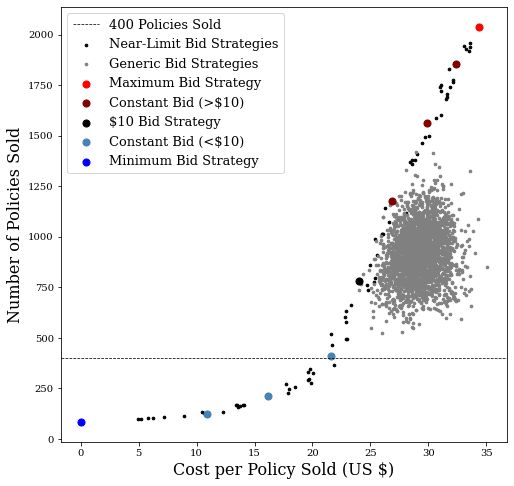

In [13]:
plt.figure(figsize=(8,8))

plt.scatter(NearLim_AdCosts, NearLim_TotSales, color='k', label='Near-Limit Bid Strategies', s=7)
plt.scatter(AdCosts, TotSales, color='0.5', label='Generic Bid Strategies', s=7)

plt.axhline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

#Include the maxed out bid strategy
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+4.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='r', label='Maximum Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', label='Constant Bid (>$10)', s=50)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00+1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)

#Include the $10 bid strategy 
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00]*35, printout=False )
plt.scatter(AdCost, TotSale, color='k', label='$10 Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00-1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', label='Constant Bid (<$10)', s=50)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00-2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)
AdCost, TotSale, TrueBids = BidStrategyStats( [10.00-3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)

#Include the all minimum bid strategy
AdCost, TotSale, TrueBids = BidStrategyStats( [MinBidVal]*35, printout=False )
plt.scatter(AdCost, TotSale, color='b', label='Minimum Bid Strategy', s=50)

plt.legend(fontsize=13,loc='best')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=16)
plt.ylabel('Number of Policies Sold', fontsize=16)

plt.show()

In [14]:
#Can we combine customer categories enough to make a small enough data set that we can feasibly
#do a full-ish search through all of the potential the bidding strategies in this model?

#Combine Not Insured and Unknown Insurance status
RootData.loc[RootData["Currently Insured"] == "unknown", "Currently Insured"] = "U/N"
RootData.loc[RootData["Currently Insured"] == "N", "Currently Insured"] = "U/N"

#Combine all >1 Number of Vehicle customers
RootData.loc[RootData["Number of Vehicles"] == 2, "Number of Vehicles"] = 23
RootData.loc[RootData["Number of Vehicles"] == 3, "Number of Vehicles"] = 23

RootData

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,U/N,23,1,M,10.0,2,False,0
1,Y,23,1,M,10.0,5,False,0
2,Y,23,2,M,10.0,5,False,0
3,U/N,23,2,S,10.0,4,False,0
4,U/N,23,2,S,10.0,2,False,0
...,...,...,...,...,...,...,...,...
9995,U/N,1,2,S,10.0,3,True,0
9996,U/N,23,2,M,10.0,3,False,0
9997,Y,23,1,S,10.0,5,False,0
9998,U/N,23,1,M,10.0,3,False,0


In [15]:
#This time we'll skip marital status altogether, since it seems unimportant

insured_vals = list( set(RootData["Currently Insured"]) )
vehicles_vals = list( set(RootData["Number of Vehicles"]) )
drivers_vals = list( set(RootData["Number of Drivers"]) )

categories_df = pd.DataFrame({
                        'Insured':[],
                        'Vehicles':[],
                        'Drivers':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                        'Total Clicks':[],
                        'Total Click Uncertainty':[],
                        'Total Policies Sold':[],
                        'Total Policies Sold Uncertainty':[],
                        'Expected Clicks at Rank 5':[],
                        'Uncertainty in Rank 5 Clicks Estimate':[],
                        'Expected Policies Sold at Rank 5':[],
                        'Uncertainty in Rank 5 Sales Estimate':[],
                        'Expected Clicks per Ad':[],
                        'AvgRank':[],
                        'Rank1':[],
                        'Rank2':[],
                        'Rank3':[],
                        'Rank4':[],
                        'Rank5':[]
                        })

#Will need the expected clicks per ad for an ad displayed in ranks 1-5
R1ExpClickPA = basic_info("rank",1,printout=False)[0]
R1ErrClickPa = basic_info("rank",1,printout=False)[1]
R2ExpClickPA = basic_info("rank",2,printout=False)[0]
R2ErrClickPa = basic_info("rank",2,printout=False)[1]
R3ExpClickPA = basic_info("rank",3,printout=False)[0]
R3ErrClickPa = basic_info("rank",3,printout=False)[1]
R4ExpClickPA = basic_info("rank",4,printout=False)[0]
R4ErrClickPa = basic_info("rank",4,printout=False)[1]
R5ExpClickPA = basic_info("rank",5,printout=False)[0]
R5ErrClickPa = basic_info("rank",5,printout=False)[1]

for insured_val in insured_vals:
    for vehicles_val in vehicles_vals:
        for drivers_val in drivers_vals:
            Ranks = [ len(RootData.loc[(RootData["rank"]==i+1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ]) for i in range(5) ]
            ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ])
            policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ])
            total_ads = len(RootData.loc[(RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ])
            if (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4]) > 0:
                #probably best to just leave out the empty unknown/3/2/S bin that has no ads
                #which is what this if statement does

                clicks_per_ad = ad_clicks/total_ads
                policies_per_ad = policies_sold/total_ads
                policies_per_click = policies_per_ad/clicks_per_ad

                err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
                err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
                err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )

                ExpClickTot = R1ExpClickPA*Ranks[0] + R2ExpClickPA*Ranks[1] + R3ExpClickPA*Ranks[2] + R4ExpClickPA*Ranks[3] + R5ExpClickPA*Ranks[4]
                AvgRank = ( 1*Ranks[0]+2*Ranks[1]+3*Ranks[2]+4*Ranks[3]+5*Ranks[4] ) / (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                ExpClickperAd = ExpClickTot/sum(Ranks)

                #Number of expected clicks if we were to place all ads for customers of these traits in rank 5
                ExpClickR5 = R5ExpClickPA*(Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                ErrClickR5 = ExpClickR5*np.sqrt(R5ErrClickPa**2)
                ExpPoliciesR5 = policies_per_click*ExpClickR5
                ErrPoliciesR5 = ExpPoliciesR5 * np.sqrt( (err_policies_per_click/policies_per_click)**2 + (ErrClickR5/ExpClickR5)**2 )

                #print(insured_val, vehicles_val, drivers_val, marital_val, AvgRank_Val, policies_per_click)
                new_row = {'Insured':insured_val, 'Vehicles':vehicles_val, 'Drivers':drivers_val,
                           'Policies Sold per Click':policies_per_click,
                           'Policies Sold per Click Uncertainty':err_policies_per_click,
                           'Total Clicks':ad_clicks, 'Total Click Uncertainty':np.sqrt(ad_clicks),
                           'Total Policies Sold':policies_sold, 'Total Policies Sold Uncertainty':np.sqrt(policies_sold),
                           'Expected Clicks at Rank 5':ExpClickR5, 'Uncertainty in Rank 5 Clicks Estimate':ErrClickR5,
                           'Expected Policies Sold at Rank 5':ExpPoliciesR5,'Uncertainty in Rank 5 Sales Estimate':ErrPoliciesR5,
                           'Expected Clicks per Ad':ExpClickperAd, 'AvgRank':AvgRank,
                           'Rank1':Ranks[0],'Rank2':Ranks[1], 'Rank3':Ranks[2],'Rank4':Ranks[3], 'Rank5':Ranks[4]
                           }
                categories_df = categories_df.append(new_row, ignore_index=True)

categories_df = categories_df.sort_values(by=['Policies Sold per Click'], ascending=False).reset_index(drop=True)
categories_df


,Insured,Vehicles,Drivers,Policies Sold per Click,Policies Sold per Click Uncertainty,Total Clicks,Total Click Uncertainty,Total Policies Sold,Total Policies Sold Uncertainty,Expected Clicks at Rank 5,Uncertainty in Rank 5 Clicks Estimate,Expected Policies Sold at Rank 5,Uncertainty in Rank 5 Sales Estimate,Expected Clicks per Ad,AvgRank,Rank1,Rank2,Rank3,Rank4,Rank5
0,U/N,1.0,1.0,0.543974,0.057032,307.0,17.521415,167.0,12.922848,24.489306,0.075621,13.321544,1.397278,0.258092,2.579913,298.0,287.0,272.0,174.0,114.0
1,U/N,1.0,2.0,0.453368,0.045420,386.0,19.646883,175.0,13.228757,24.703186,0.076282,11.199631,1.122541,0.323762,2.046753,433.0,332.0,293.0,97.0,0.0
2,Y,1.0,1.0,0.426087,0.076991,115.0,10.723805,49.0,7.000000,12.062855,0.037249,5.139825,0.928865,0.187023,3.044326,60.0,124.0,172.0,147.0,61.0
3,U/N,23.0,1.0,0.414141,0.040450,396.0,19.899749,164.0,12.806248,46.647316,0.144044,19.318585,1.887828,0.187078,3.213205,367.0,329.0,508.0,426.0,551.0
4,U/N,23.0,2.0,0.382979,0.039349,376.0,19.390719,144.0,12.000000,44.914884,0.138694,17.201445,1.768149,0.195170,3.100000,346.0,369.0,534.0,431.0,420.0
5,Y,1.0,2.0,0.313725,0.055090,153.0,12.369317,48.0,6.928203,12.340899,0.038108,3.871655,0.679969,0.244658,2.535529,107.0,167.0,190.0,113.0,0.0
6,Y,23.0,2.0,0.257576,0.070863,66.0,8.124038,17.0,4.123106,24.959843,0.077074,6.429050,1.768846,0.062062,4.331620,0.0,0.0,211.0,358.0,598.0
7,Y,23.0,1.0,0.240506,0.062295,79.0,8.888194,19.0,4.358899,23.762113,0.073376,5.714938,1.480373,0.064439,4.293429,0.0,0.0,221.0,343.0,547.0


In [16]:
#This is the amount (in dollars) that we are assuming will increase a bid's rank placement by 1 spot
RankValue = 2.50

# We'll again assume that the lowest possible bid one can make is $0.01,
# since I doubt the search host would let you bid $0.00
MinBidVal = 0.01

PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])

#Sparser PossibleBids to make calculation faster
PossibleBids = np.array([10.00+4.0*RankValue, 10.00+2.0*RankValue, 10.00, 10.00-2.0*RankValue, MinBidVal])


AdCosts = []
TotSales = []
SetBids = []

for s0_i in range(len(PossibleBids)):
    for s1_i in range(len(PossibleBids)):
        for s2_i in range(len(PossibleBids)):
            for s3_i in range(len(PossibleBids)):
                for s4_i in range(len(PossibleBids)):
                    for s5_i in range(len(PossibleBids)):
                        for s6_i in range(len(PossibleBids)):
                            for s7_i in range(len(PossibleBids)):
                                TestBids = [PossibleBids[s0_i],
                                            PossibleBids[s1_i],
                                            PossibleBids[s2_i],
                                            PossibleBids[s3_i],
                                            PossibleBids[s4_i],
                                            PossibleBids[s5_i],
                                            PossibleBids[s6_i],
                                            PossibleBids[s7_i]]
                                AdCost, TotSale, TrueBids = BidStrategyStats(TestBids, printout=False)
                                SetBids.append(TrueBids)
                                AdCosts.append(AdCost)
                                TotSales.append(TotSale)


In [17]:
#Sample another subset of the full PossibleBids space to get a more complete picture of the model
PossibleBids = np.array([10.00+3.0*RankValue, 10.00+1.0*RankValue, 10.00, 10.00-1.0*RankValue, 10.00-3.0*RankValue])

for s0_i in range(len(PossibleBids)):
    for s1_i in range(len(PossibleBids)):
        for s2_i in range(len(PossibleBids)):
            for s3_i in range(len(PossibleBids)):
                for s4_i in range(len(PossibleBids)):
                    for s5_i in range(len(PossibleBids)):
                        for s6_i in range(len(PossibleBids)):
                            for s7_i in range(len(PossibleBids)):
                                TestBids = [PossibleBids[s0_i],
                                            PossibleBids[s1_i],
                                            PossibleBids[s2_i],
                                            PossibleBids[s3_i],
                                            PossibleBids[s4_i],
                                            PossibleBids[s5_i],
                                            PossibleBids[s6_i],
                                            PossibleBids[s7_i]]
                                AdCost, TotSale, TrueBids = BidStrategyStats(TestBids, printout=False)
                                SetBids.append(TrueBids)
                                AdCosts.append(AdCost)
                                TotSales.append(TotSale)

In [24]:
#Get a list of the continuum of constant-bid strategies
ConstSetBids = []
ConstAdCosts = []
ConstTotSales = []

MorePossibleBids = np.append(
    np.linspace(10.00+4.0*RankValue,10.00-4.0*RankValue,num=6000,endpoint=False),
    np.array([MinBidVal])
    )

for i in range(len(MorePossibleBids)):
    AdCost, TotSale, TrueBids = BidStrategyStats([MorePossibleBids[i]]*8, printout=False)
    ConstSetBids.append(TrueBids)
    ConstAdCosts.append(AdCost)
    ConstTotSales.append(TotSale)

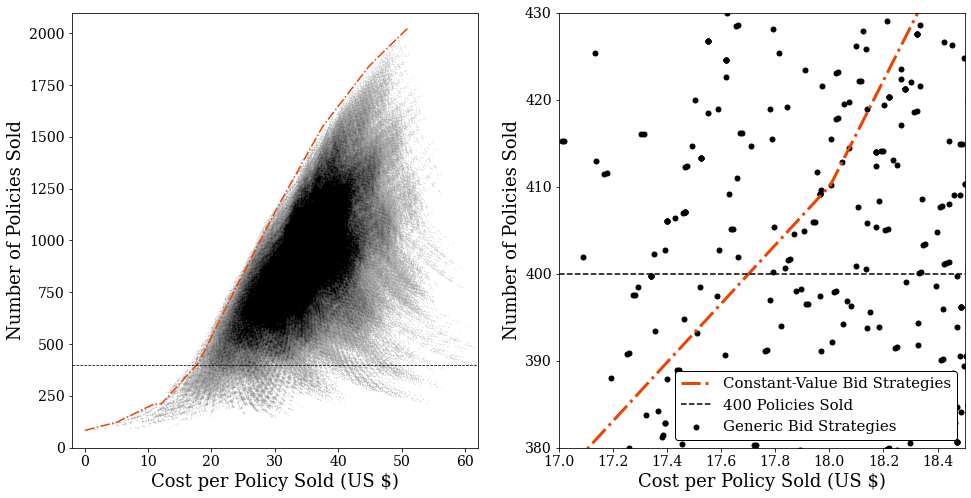

In [33]:
plt.figure(figsize=(16,8))

#Plot full space
plt.subplot(1,2,1)

plt.scatter(AdCosts, TotSales, color='0.8', s=0.025)
plt.scatter(AdCosts, TotSales, color='k', label='Generic Bid Strategies', s=0.5, alpha=0.006)
plt.plot(ConstAdCosts, ConstTotSales, color=Orange120, label='Flat Bid Strategies', linewidth=1.5, linestyle='-.')
plt.axhline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

#plt.legend(fontsize=13,loc='best')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-2.00,62.00)
plt.ylim(0,2100)

#Now zoom in around the 400 policies sold region
plt.subplot(1,2,2)

plt.scatter(AdCosts, TotSales, color='k', label='Generic Bid Strategies', s=25)
plt.plot(ConstAdCosts, ConstTotSales, color=Orange120, label='Constant-Value Bid Strategies', linewidth=3.0, linestyle='-.')
plt.axhline(400,color='k',linestyle='--',label='400 Policies Sold',linewidth=1.5)

plt.legend(fontsize=15,loc='lower right',framealpha=1.0,edgecolor='k')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(17.00,18.50)
plt.ylim(380,430)

plt.show()

Here we have combined a few of the customer categories (like Unknown and No Insurance as well as 2 and 3 Vehicles) and ignored the seemingly negligible impact of Marital Status so that we could afford to look at the full parameter space of the simplified model. Although even in this smaller parameter space we still had to use sparse sampling of the possible bids to make the computation feasible.

It would seem that the general features we identified earlier via random sampling of the full categories -- namely, that there is an ideal limit for this bid/rank model that is traced out by the constant bid strategies, and that most mixed bid models will do worse than this limit -- holds true when we search the entire parameter space. It's notable that there are a handful of mixed bid strategies that slightly outperform the curve of constant bidding (see the few points above the orange curve in the right panel), but given that exploring them is rather expensive and that this model is likely not accurate to that level of discernment anyway, it seems the best strategy here would just be to take the curve of constant bidding as our best bet and go from there.

In [26]:
#Let's inspect the bid strategy that offers the cheapest route to 400 sales

opt_ind = [i for i,x in enumerate(ConstTotSales) if x>400][-1]
BidsToHitGoal = ConstSetBids[opt_ind]
print("The following bid strategy is expected to yield "+str(round(ConstTotSales[opt_ind],1))+" policy sales, at a cost per policy of $"+str(round(ConstAdCosts[opt_ind],2))+"." )
print()


for i in range(len(BidsToHitGoal)):
    CustomerInfo = categories_df.iloc[i][["Insured","Vehicles","Drivers"]].values
    CustomerInfo = np.where(CustomerInfo == 23, '2/3', CustomerInfo)
    print("Insured: "+str(CustomerInfo[0]),'\t',
          "Vehicles: "+str(CustomerInfo[1]),'\t',
          "Drivers: "+str(CustomerInfo[2]),'\t',
          "Marital Status: "+"M/S",'\t',
          "Bid: $"+str(round(BidsToHitGoal[i],2)),
         )




The following bid strategy is expected to yield 400.1 policy sales, at a cost per policy of $17.7.

Insured: U/N 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: U/N 	 Vehicles: 1.0 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: Y 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: U/N 	 Vehicles: 2/3 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: U/N 	 Vehicles: 2/3 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: Y 	 Vehicles: 1.0 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: Y 	 Vehicles: 2/3 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: Y 	 Vehicles: 2/3 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
